## Credit Risk Prediction ## 

Credit risk is the possibility of a loss resulting from a borrower's failure to repay a loan or meet contractual obligations.  

In this project, the objective is to classify a person as 'good' or 'bad' credit based on attributes ['age', 'income', 'credit_history'..etc].  

We will build model by applying different algorithm (e.g 'KNN', 'Logistic_Regression') and implement techniques (e.g GridSearchCV) to fine-tune hyperparameters for model improvement.


#### Import libraries ####

In [4]:
!pip install xgboost

     --------------------------------------- 89.1/89.1 MB 21.8 MB/s eta 0:00:00


In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import auc,roc_curve, accuracy_score, confusion_matrix, roc_auc_score, classification_report, precision_recall_fscore_support
import xgboost as xgb
import os

In [6]:
# Read dataset
credit_df = pd.read_csv('../Credit_Risk_Prediction/credit_risk_dataset.csv')
credit_df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [7]:
# Check data size
credit_df.shape

(32581, 12)

In [8]:
# Check any null value in dataset
credit_df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [9]:
# Check the mode, median for the two features
print('person_emp_length mode {}'.format(credit_df['person_emp_length'].mode()[0]))
print('person_emp_length median {}'.format(credit_df['person_emp_length'].median()))
print('loan_int_rate mode {}'.format(credit_df['loan_int_rate'].mode()[0]))
print('loan_int_rate median {}'.format(credit_df['loan_int_rate'].median()))

person_emp_length mode 0.0
person_emp_length median 4.0
loan_int_rate mode 7.51
loan_int_rate median 10.99


In [10]:
# Replace NaN values with mode/median, to ensure the outcome is more conservative
credit_df['person_emp_length'].fillna(credit_df['person_emp_length'].mode()[0], inplace=True)
credit_df['loan_int_rate'].fillna(credit_df['loan_int_rate'].median(), inplace=True)

In [11]:
# Check if the NaN values are replace
credit_df.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [12]:
# List out numerical features
num_cols = pd.DataFrame(credit_df[credit_df.select_dtypes(include=['float', 'int']).columns])
num_cols.columns

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_cred_hist_length'],
      dtype='object')

#### Data Visualization ####

c:\Users\808485\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\808485\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\808485\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-

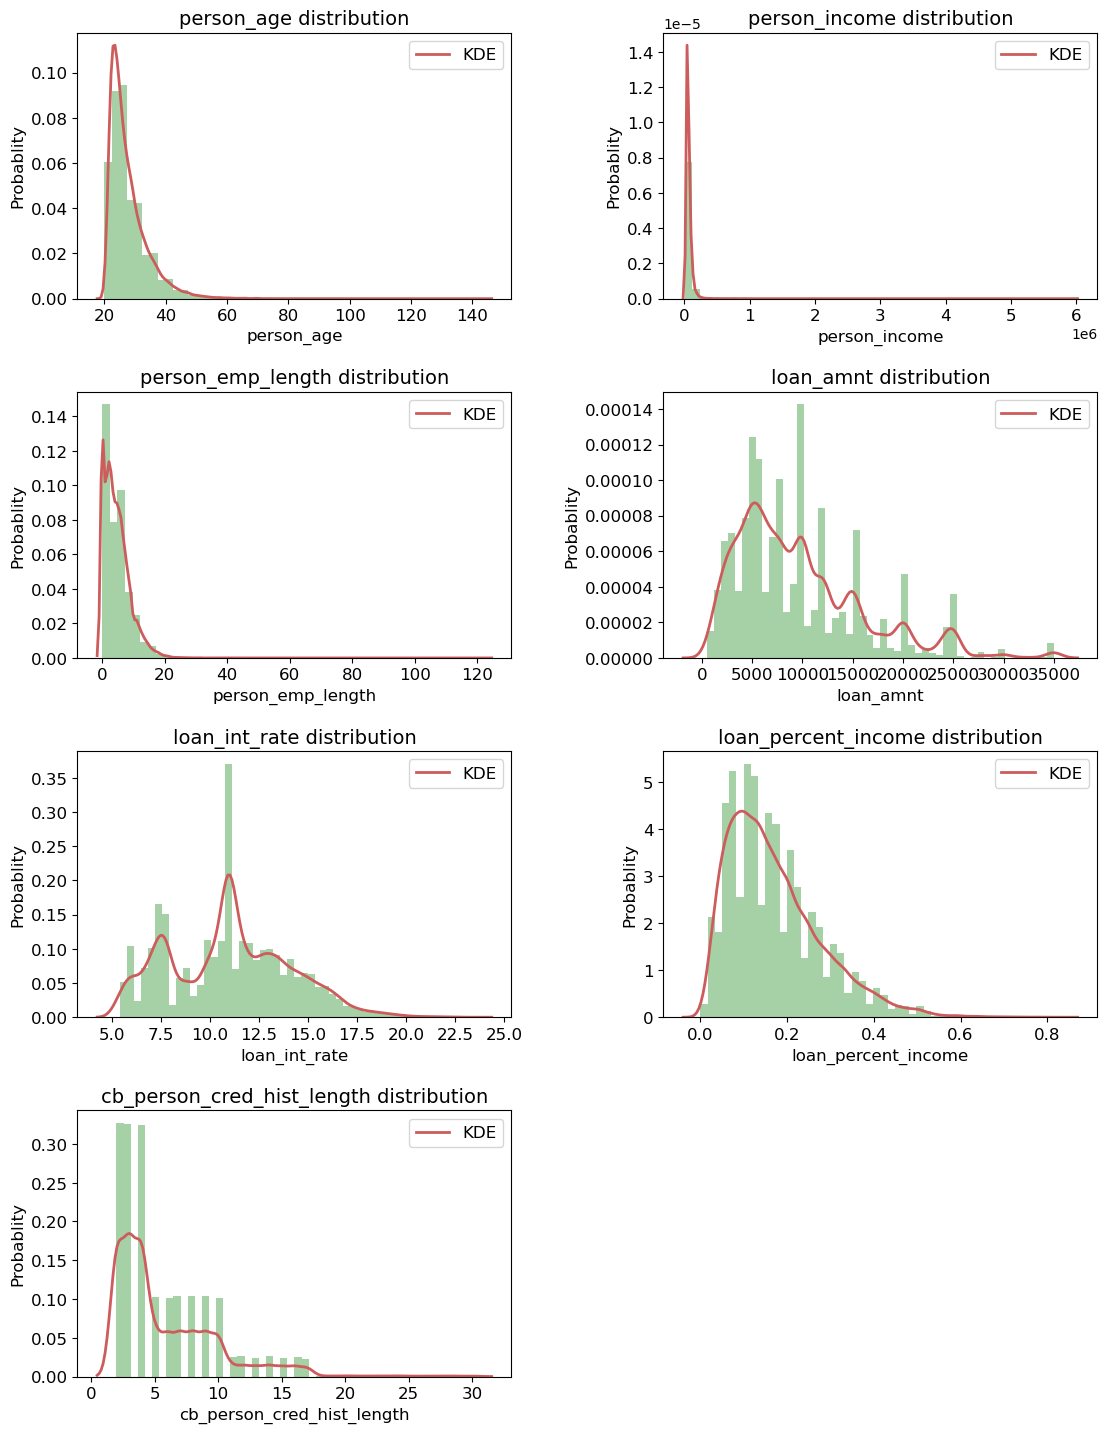

In [17]:
# Let's drop the target variable ['loan_status']

num_cols_hist = num_cols.drop(['loan_status'], axis=1)

# Plot graph
plt.figure(figsize=(12,16))

for i, col in enumerate(num_cols_hist.columns):
    idx = int('42'+ str(i+1))
    plt.subplot(idx)
    sns.distplot(num_cols_hist[col], color='forestgreen', 
                 kde_kws={'color': 'indianred', 'lw': 2, 'label': 'KDE'})
    plt.title(col+' distribution', fontsize=14)
    plt.ylabel('Probablity', fontsize=12)
    plt.xlabel(col, fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(['KDE'], prop={"size":12})

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35,
                    wspace=0.35)
plt.show()

In [18]:
credit_df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,32581.000000,32581.000000,32581.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.658114,9589.371106,11.009620,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.159669,6322.086646,3.081611,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,8.490000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.110000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


Most of the distributions are skewed.  
person_age : Distribution among people with age group 20 to 60.   
person_emp_length : Most people with employment<40 years.  
person_income: The income range is between 0 to 1million.  
We can try to eliminate some extreme values(remove the outliers).

In [19]:
credit_df_revised = credit_df[credit_df['person_age']<=100]
credit_df_revised = credit_df_revised[credit_df_revised['person_emp_length']<=60]
credit_df_revised = credit_df_revised[credit_df_revised['person_income']<=4e6]

In [20]:
# Store revised numerical features
credit_df_revised_num_cols = pd.DataFrame(credit_df_revised[credit_df_revised.select_dtypes(include=['float', 'int']).columns])

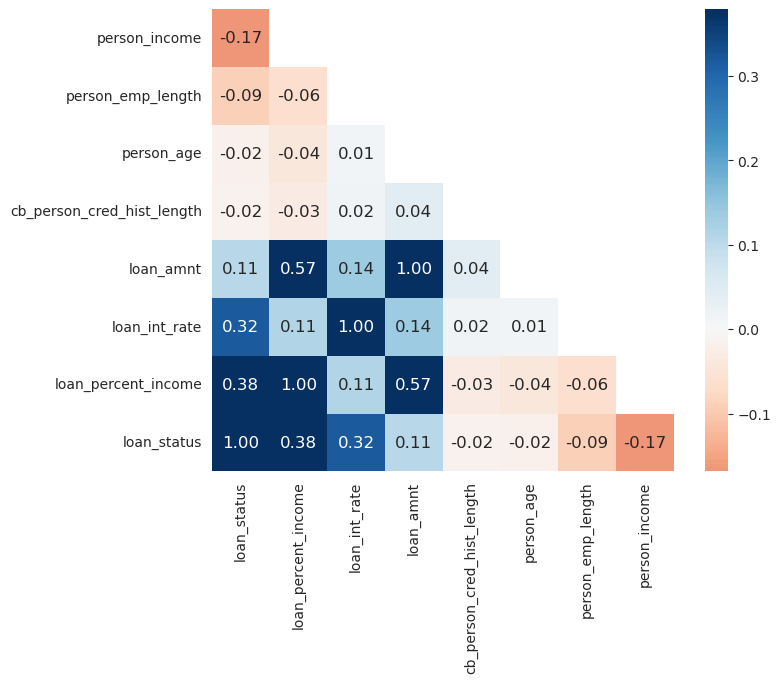

In [22]:
# plot correlation between each feature
corr = credit_df_revised_num_cols.corr().sort_values('loan_status', axis=1, ascending=False)
corr = corr.sort_values('loan_status', axis=0, ascending=True)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(8, 6))
    ax = sns.heatmap(corr, mask=mask, vmin=corr.loan_status.min(), 
                     vmax=corr.drop(['loan_status'], axis=0).loan_status.max(),
                     square=True, annot=True, fmt='.2f',
                     center=0, cmap='RdBu',annot_kws={"size": 12})

'person_income', 'person_emp_length' & 'person_age' are negatively correlated with 'loan_status'.  
It means people with higher income, longer employment period, greater age are at low risk.
'loan_percent_income', 'loan_int_rate' & 'loan_amnt' are positively correlated with 'loan_status'.
It means people with higher loan percentage with respect to income are at high risk.

In [23]:
# List out categorical features
cat_cols = pd.DataFrame(credit_df_revised[credit_df_revised.select_dtypes(include=['object']).columns])
cat_cols.columns

Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object')

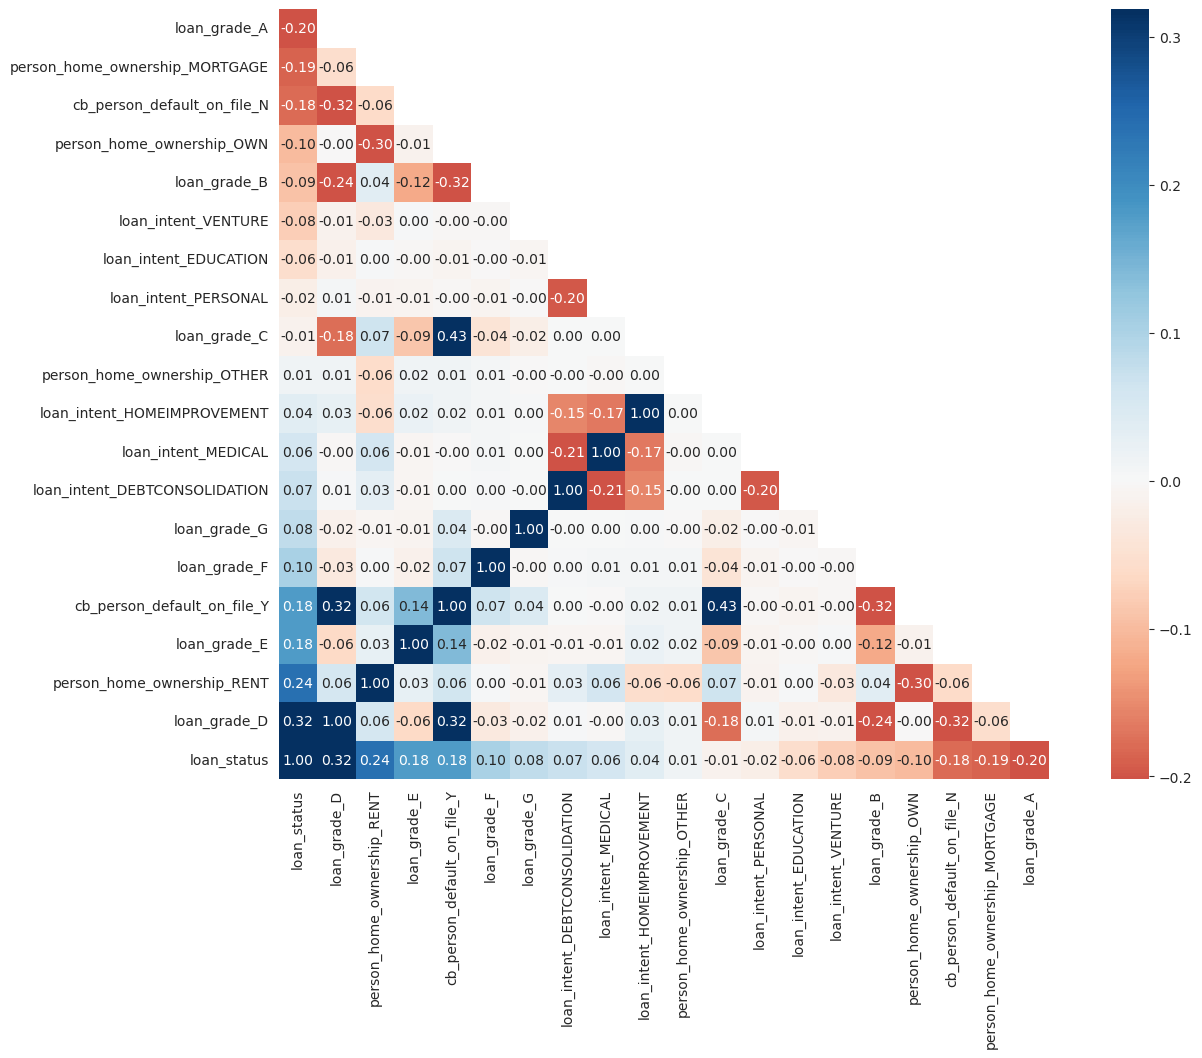

In [26]:
# Encode categorical features
credit_df_revised_cat_cols = pd.get_dummies(cat_cols)
cat_cols_corr = pd.concat([credit_df_revised_cat_cols, credit_df_revised['loan_status']], axis=1)
# Plot figure
corr = cat_cols_corr.corr().sort_values('loan_status', axis=1, ascending=False)
corr = corr.sort_values('loan_status', axis=0, ascending=True)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 10))
    ax = sns.heatmap(corr, mask=mask, vmin=corr.loan_status.min(), 
                     vmax=corr.drop(['loan_status'], axis=0).loan_status.max(), 
                     square=True, annot=True, fmt='.2f',
                     center=0, cmap='RdBu',annot_kws={"size": 10})

In [27]:
# Concatenate both numerial and categorical features
credit_df_revised = pd.concat([credit_df_revised_num_cols, credit_df_revised_cat_cols], axis=1)
credit_df_revised.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
1,21,9600,5.0,1000,11.14,0,0.10,2,0,0,...,0,0,1,0,0,0,0,0,1,0
2,25,9600,1.0,5500,12.87,1,0.57,3,1,0,...,0,0,0,1,0,0,0,0,1,0
3,23,65500,4.0,35000,15.23,1,0.53,2,0,0,...,0,0,0,1,0,0,0,0,1,0
4,24,54400,8.0,35000,14.27,1,0.55,4,0,0,...,0,0,0,1,0,0,0,0,0,1
5,21,9900,2.0,2500,7.14,1,0.25,2,0,0,...,1,1,0,0,0,0,0,0,1,0


In [28]:
credit_df_revised.shape

(32574, 27)

In [29]:
print ('The revised dataset has {} numerical features and {} categorical features'
       .format(len(credit_df_revised_num_cols.columns)-1, len(credit_df_revised_cat_cols.columns)))

The revised dataset has 7 numerical features and 19 categorical features


#### Model Building ####

In [31]:
# Let's split dataset into training and test set
target = credit_df_revised['loan_status']
features = credit_df_revised.drop('loan_status', axis=1)
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42, test_size=0.2)

X_train.shape, y_train.shape

((26059, 26), (26059,))

In [32]:
# Define a function to assess model's performance
def model_assess(model, name='Default'):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    preds_proba = model.predict_proba(X_test)
    print(name, '\n',classification_report(y_test, model.predict(X_test)))

In [65]:
# Let's build model
knn = KNeighborsClassifier(n_neighbors=150)
model_assess(knn, name='KNN')

log_reg = LogisticRegression(random_state=42)
model_assess(log_reg, 'LogisticRegression')

tree = DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=1, random_state=42)
model_assess(tree, 'DecisionTreeClassifier')

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
model_assess(xgb_model, 'XGBoostClassifier')

c:\Users\808485\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\808485\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepd

KNN 
               precision    recall  f1-score   support

           0       0.85      0.96      0.90      5099
           1       0.74      0.40      0.52      1416

    accuracy                           0.84      6515
   macro avg       0.79      0.68      0.71      6515
weighted avg       0.83      0.84      0.82      6515

LogisticRegression 
               precision    recall  f1-score   support

           0       0.81      0.99      0.89      5099
           1       0.75      0.16      0.26      1416

    accuracy                           0.81      6515
   macro avg       0.78      0.57      0.57      6515
weighted avg       0.80      0.81      0.75      6515

DecisionTreeClassifier 
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      5099
           1       0.95      0.72      0.82      1416

    accuracy                           0.93      6515
   macro avg       0.94      0.85      0.89      6515
weighted avg       0.9

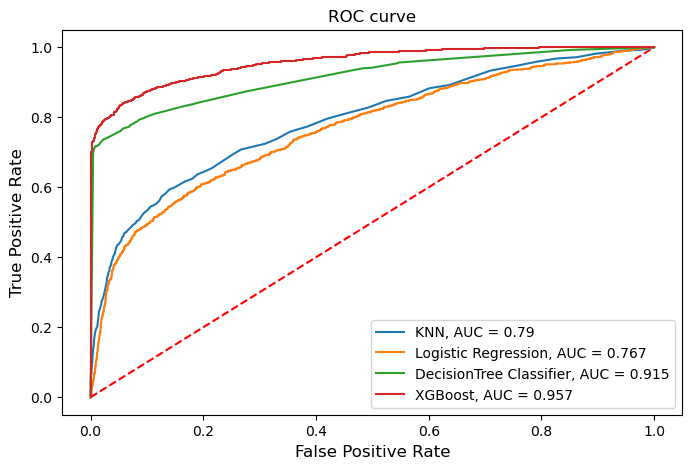

In [50]:
# Plot ROC curve

fig = plt.figure(figsize=(8,5))
plt.plot([0, 1], [0, 1],'r--')

#KNN
preds_proba_knn = knn.predict_proba(X_test)
probsknn = preds_proba_knn[:, 1]
fpr, tpr, thresh = roc_curve(y_test, probsknn)
aucknn = roc_auc_score(y_test, probsknn)
plt.plot(fpr, tpr, label=f'KNN, AUC = {str(round(aucknn,3))}')

#Logistic Regression
preds_proba_lg = log_reg.predict_proba(X_test)
probslg = preds_proba_lg[:, 1]
fpr, tpr, thresh = roc_curve(y_test, probslg)
auclg = roc_auc_score(y_test, probslg)
plt.plot(fpr, tpr, label=f'Logistic Regression, AUC = {str(round(auclg,3))}')

#DecisionTree Classifier
preds_proba_D_tree = tree.predict_proba(X_test)
probsD_tree = preds_proba_D_tree[:, 1]
fpr, tpr, thresh = roc_curve(y_test, probsD_tree)
auclg = roc_auc_score(y_test, probsD_tree)
plt.plot(fpr, tpr, label=f'DecisionTree Classifier, AUC = {str(round(auclg,3))}')

#XGBoost
preds_proba_xgb = xgb_model.predict_proba(X_test)
probsxgb = preds_proba_xgb[:, 1]
fpr, tpr, thresh = roc_curve(y_test, probsxgb)
aucxgb = roc_auc_score(y_test, probsxgb)
plt.plot(fpr, tpr, label=f'XGBoost, AUC = {str(round(aucxgb,3))}')
plt.ylabel("True Positive Rate", fontsize=12)
plt.xlabel("False Positive Rate", fontsize=12)
plt.title("ROC curve")
plt.rcParams['axes.titlesize'] = 16
plt.legend()
plt.show()

#### Feature Importance ####

In [74]:
feature_importance = pd.DataFrame({'feature': X_train.columns, 
                                   'importance': xgb_model.feature_importances_})

new_features_df = feature_importance[feature_importance['importance']>0
                                    ].sort_values(by=['importance'],ascending=False)

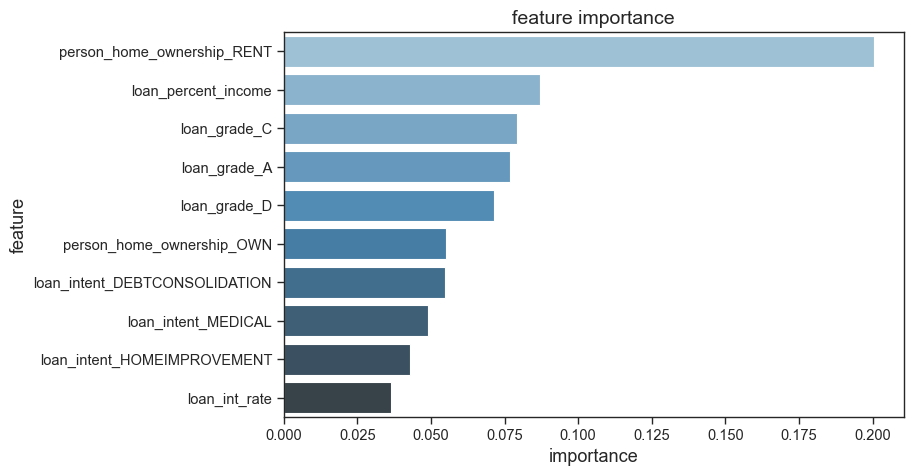

In [75]:
sns.set(context='paper', style='ticks',  font='sans-serif', 
        font_scale=1.2, color_codes=True, rc=None)
figure, ax = plt.subplots(figsize=(8, 5))
ax=sns.barplot(data = new_features_df[:10],
              y='feature',
              x='importance',
              palette='Blues_d') # rocket, Blues_d
ax.set_title('feature importance', fontsize=14)
ax.set_xlabel('importance', fontsize=13)
ax.set_ylabel('feature', fontsize=13)
plt.show()

#### Hyperparameter Tuning ####

In [76]:
# RandomizedSearchCV
params = {
    "colsample_bytree": uniform(0.9, 0.1), # 0.9-1 0.9 is the lower bound, 0.1 is the range
    "gamma": uniform(0.2, 0.3),# 0.2-0.5
    "learning_rate": uniform(0.2, 0.2), # 0.2-0.4 
    "max_depth": randint(4, 6), # 4, 5, 6
    "n_estimators": randint(100, 300), # 100-300
    "subsample": uniform(0.9, 0.1) # 0.9-1
}

Random_CV = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, 
                            n_iter=100, cv=3, verbose=2, n_jobs=16, return_train_score=True)

Random_CV.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           callbacks=None, colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=0, gpu_id=-1,
                                           grow_policy='depthwise',
                                           importance_type=None,
                                           interaction_constraints='',
                                           learning_rate=0.300...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000020D8F5B6

In [77]:
# function to return the top selcted models
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
report_best_scores(Random_CV.cv_results_, 3)

Model with rank: 1
Mean validation score: 0.935 (std: 0.001)
Parameters: {'colsample_bytree': 0.9094442960755929, 'gamma': 0.40490203202490704, 'learning_rate': 0.2142377296920458, 'max_depth': 5, 'n_estimators': 192, 'subsample': 0.9844875310969454}

Model with rank: 2
Mean validation score: 0.934 (std: 0.002)
Parameters: {'colsample_bytree': 0.9556005038642584, 'gamma': 0.2968059164832751, 'learning_rate': 0.20868015665963457, 'max_depth': 4, 'n_estimators': 263, 'subsample': 0.9553854284401321}

Model with rank: 3
Mean validation score: 0.934 (std: 0.002)
Parameters: {'colsample_bytree': 0.9842284774594998, 'gamma': 0.33492624001092974, 'learning_rate': 0.2790300472003629, 'max_depth': 5, 'n_estimators': 113, 'subsample': 0.9727271995856421}



In [78]:
Random_best_xgb = Random_CV.best_estimator_
Random_best_xgb.fit(X_train, np.ravel(y_train)) 
preds_proba_Random = Random_best_xgb.predict_proba(X_test)
probs_Random = preds_proba_Random[:, 1]
Random_bestauc = roc_auc_score(y_test, probs_Random)
print ('xgb base model AUROC socre: {}'.format(aucxgb))
print ('xgb best model using RandomizedSearchCV AUROC socre: {}'.format(Random_bestauc))

xgb base model AUROC socre: 0.9566901619127712
xgb best model using RandomizedSearchCV AUROC socre: 0.9576491402435174


In [79]:
# GridSearchCV
params = {
    "colsample_bytree": [0.91, 0.96],
    "gamma": [0.41],
    "learning_rate": [0.21], # default 0.1 
    "max_depth": [5], # default 3
    "n_estimators": [192, 263, 113], # default 100
    "subsample": [0.98, 0.96, 0.97]
}

Grid_CV = GridSearchCV(xgb_model, param_grid=params, cv=3, verbose=1, n_jobs=16, return_train_score=True)
Grid_CV.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012...
                                     max_leaves=0, min_child_weight=1,
                                     missing=nan, monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, predictor='au

In [80]:
report_best_scores(Grid_CV.cv_results_, 3)

Model with rank: 1
Mean validation score: 0.935 (std: 0.002)
Parameters: {'colsample_bytree': 0.96, 'gamma': 0.41, 'learning_rate': 0.21, 'max_depth': 5, 'n_estimators': 192, 'subsample': 0.96}

Model with rank: 2
Mean validation score: 0.935 (std: 0.002)
Parameters: {'colsample_bytree': 0.96, 'gamma': 0.41, 'learning_rate': 0.21, 'max_depth': 5, 'n_estimators': 113, 'subsample': 0.98}

Model with rank: 3
Mean validation score: 0.934 (std: 0.002)
Parameters: {'colsample_bytree': 0.96, 'gamma': 0.41, 'learning_rate': 0.21, 'max_depth': 5, 'n_estimators': 192, 'subsample': 0.97}



In [81]:
Grid_best_xgb = Grid_CV.best_estimator_
Grid_best_xgb.fit(X_train, np.ravel(y_train)) 
preds_proba_Grid = Grid_best_xgb.predict_proba(X_test)
probs_Grid = preds_proba_Grid[:, 1]
Grid_bestauc = roc_auc_score(y_test, probs_Grid)
print ('xgb base model AUROC socre: {}'.format(aucxgb))
print ('xgb best model using RandomizedSearchCV AUROC socre: {}'.format(Random_bestauc))
print ('xgb best model using GridSearchCV AUROC socre: {}'.format(Grid_bestauc))

xgb base model AUROC socre: 0.9566901619127712
xgb best model using RandomizedSearchCV AUROC socre: 0.9576491402435174
xgb best model using GridSearchCV AUROC socre: 0.9575841834501725


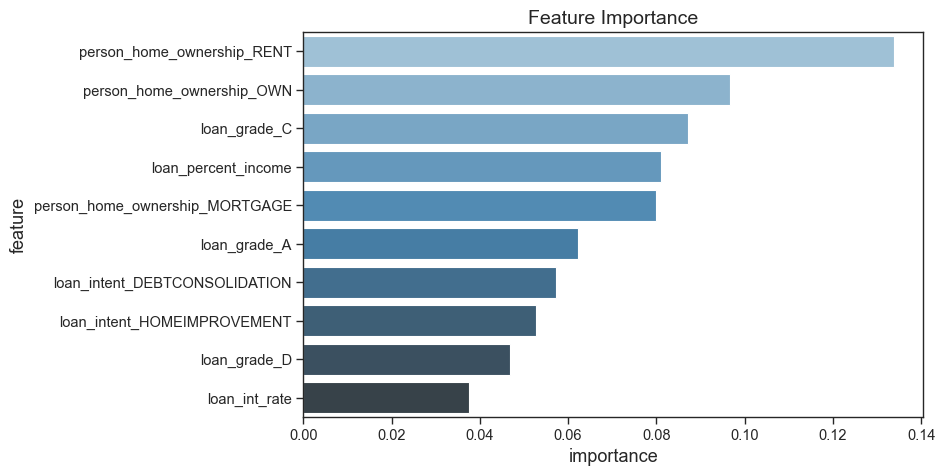

In [82]:
# Plot features importance
feature_importance = pd.DataFrame({'feature': X_train.columns, 
                                   'importance': Grid_best_xgb.feature_importances_})

new_features_df = feature_importance[feature_importance['importance']>0
                                    ].sort_values(by=['importance'],ascending=False)

sns.set(context='paper', style='ticks',  font='sans-serif', 
        font_scale=1.2, color_codes=True, rc=None)
figure, ax = plt.subplots(figsize=(8, 5))
ax=sns.barplot(data = new_features_df[:10],
              y='feature',
              x='importance',
              palette='Blues_d') # rocket, Blues_d
ax.set_title('Feature Importance', fontsize=14)
ax.set_xlabel('importance', fontsize=13)
ax.set_ylabel('feature', fontsize=13)
plt.show()

In [83]:
# list out the top 10 important features
new_features_df.head(10)

,feature,importance
10,person_home_ownership_RENT,0.133799
9,person_home_ownership_OWN,0.096792
19,loan_grade_C,0.087223
5,loan_percent_income,0.080937
7,person_home_ownership_MORTGAGE,0.079902
17,loan_grade_A,0.062150
11,loan_intent_DEBTCONSOLIDATION,0.057219
13,loan_intent_HOMEIMPROVEMENT,0.052636
20,loan_grade_D,0.046883
4,loan_int_rate,0.037593


In [84]:
# Let's select only top 20 features and model training
new_features = new_features_df['feature'][0:20]
new_features

10        person_home_ownership_RENT
9          person_home_ownership_OWN
19                      loan_grade_C
5                loan_percent_income
7     person_home_ownership_MORTGAGE
17                      loan_grade_A
11     loan_intent_DEBTCONSOLIDATION
13       loan_intent_HOMEIMPROVEMENT
20                      loan_grade_D
4                      loan_int_rate
14               loan_intent_MEDICAL
8        person_home_ownership_OTHER
16               loan_intent_VENTURE
18                      loan_grade_B
21                      loan_grade_E
23                      loan_grade_G
1                      person_income
2                  person_emp_length
22                      loan_grade_F
24       cb_person_default_on_file_N
Name: feature, dtype: object

In [85]:
# Split dataset
new_features_df = pd.DataFrame(credit_df_revised[new_features])
new_features_df.shape

(32574, 20)

In [86]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(new_features_df, target, 
                                                                    random_state=42, test_size=.30)
print('The train dataset has {} data\nThe test dataset has {} data'.
      format(X_train.shape[0], X_test.shape[0]))

The train dataset has 26059 data
The test dataset has 6515 data


In [88]:
# RandomizedSearchCV
params = {
    "colsample_bytree": uniform(0.9, 0.1), # 0.9-1 0.9 is the lower bound, 0.1 is the range
    "gamma": uniform(0.2, 0.3),# 0.2-0.5
    "learning_rate": uniform(0.2, 0.2), # 0.2-0.4 
    "max_depth": randint(4, 6), # 4, 5, 6
    "n_estimators": randint(100, 300), # 100-300
    "subsample": uniform(0.9, 0.1) # 0.9-1
}

Random_CV = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, 
                            n_iter=100, cv=3, verbose=2, n_jobs=16, return_train_score=True)

Random_CV.fit(X_train1, y_train1)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           callbacks=None, colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=0, gpu_id=-1,
                                           grow_policy='depthwise',
                                           importance_type=None,
                                           interaction_constraints='',
                                           learning_rate=0.300...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000020D8F591

In [89]:
report_best_scores(Random_CV.cv_results_, 3)

Model with rank: 1
Mean validation score: 0.932 (std: 0.001)
Parameters: {'colsample_bytree': 0.9493025657771805, 'gamma': 0.2249853233585779, 'learning_rate': 0.21834082945169622, 'max_depth': 5, 'n_estimators': 124, 'subsample': 0.9553703052345801}

Model with rank: 2
Mean validation score: 0.932 (std: 0.001)
Parameters: {'colsample_bytree': 0.9712179221347537, 'gamma': 0.27117472624904004, 'learning_rate': 0.26507993963185356, 'max_depth': 5, 'n_estimators': 227, 'subsample': 0.9744170523056562}

Model with rank: 3
Mean validation score: 0.932 (std: 0.001)
Parameters: {'colsample_bytree': 0.9633101457273268, 'gamma': 0.30170893731461024, 'learning_rate': 0.2698419149225322, 'max_depth': 5, 'n_estimators': 230, 'subsample': 0.9856324291878092}



In [91]:
Random_best_xgb = Random_CV.best_estimator_
Random_best_xgb.fit(X_train1, np.ravel(y_train1)) 
preds_proba_Random = Random_best_xgb.predict_proba(X_test1)
probs_Random = preds_proba_Random[:, 1]
Random_bestauc = roc_auc_score(y_test1, probs_Random)
print ('xgb base model AUROC socre: {}'.format(aucxgb))
print ('xgb best model using RandomizedSearchCV AUROC socre: {}'.format(Random_bestauc))

xgb base model AUROC socre: 0.9566901619127712
xgb best model using RandomizedSearchCV AUROC socre: 0.954152499247198


With dropping some features, the model performance does not improve significantly.

In [92]:
# Let's optimize threshold

preds = Grid_best_xgb.predict_proba(X_test) # 1st col = pred val, 2nd col = pred prob

pred_probs = pd.DataFrame(preds[:,1],columns = ['Default Probability'])

pd.concat([pred_probs, y_test.reset_index(drop=True)],axis=1)
thresh = np.linspace(0,1,41)
thresh

array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
       0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
       0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
       0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
       0.9  , 0.925, 0.95 , 0.975, 1.   ])

In [95]:
def optimize_threshold(predict,thresholds =thresh, y_true = y_test):
    data = predict
    
    def_recalls = []
    nondef_recalls = []
    accs =[]

    
    for threshold in thresholds:
        # predicted values for each threshold
        data['loan_status'] = data['Default Probability'].apply(lambda x: 1 if x > threshold else 0 )
        
        accs.append(accuracy_score(y_true, data['loan_status']))
        
        stats = precision_recall_fscore_support(y_true, data['loan_status'], zero_division=0)
        
        def_recalls.append(stats[1][1])
        nondef_recalls.append(stats[1][0])
        
        
    return accs, def_recalls, nondef_recalls

accs, def_recalls, nondef_recalls = optimize_threshold(pred_probs)

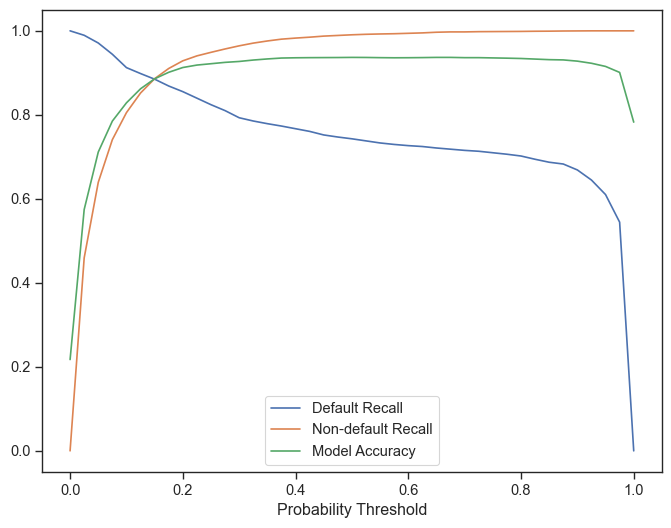

In [96]:
figure = plt.subplots(figsize=(8, 6))
plt.plot(thresh,def_recalls)
plt.plot(thresh,nondef_recalls)
plt.plot(thresh,accs)
plt.xlabel("Probability Threshold")
plt.legend(["Default Recall","Non-default Recall","Model Accuracy"])
plt.show()

In [97]:
optim_threshold = accs.index(max(accs))

print('The model accuracy is {} using the optimal probabilty threshold'
      .format(round(accs[optim_threshold],3)))

print ('The optimal probabilty threshold is {}'.format(thresh[optim_threshold]))

The model accuracy is 0.937 using the optimal probabilty threshold
The optimal probabilty threshold is 0.5


XGBClassifier outperforms other models, with 0.957 AUROC score compared to 'KNN', 'Logistic_Regression' and 'Decision Tree'.  

The optimal probability threshold is 0.5, with accuracy of 0.937.